# Librairies

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

2024-11-13 09:21:50.456166: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-13 09:21:50.568917: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-13 09:21:50.679931: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731486110.811077   11762 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731486110.848897   11762 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-13 09:21:51.078355: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

# Chargement de données

In [4]:
train_base_dir = '../Data/Data/train/'
clear_dir = os.path.join(train_base_dir, 'clear')
classes = ['clear', 'distorsion1', 'distorsion2', 'distorsion3','mvt1','mvt2','mvt3','gauss1','gauss2','gauss3','pixel1','pixel2','pixel3'] 

def verifier_et_lister_contenu(repertoire):
    if os.path.exists(repertoire):
        print(f"Le dossier '{repertoire}' contient les fichiers suivants :")
        for filename in os.listdir(repertoire):
            print(filename)
    else:
        print(f"Le dossier '{repertoire}' n'existe pas. Vérifiez le chemin.")

verifier_et_lister_contenu(clear_dir)


image_size = (224, 224)
batch_size = 64  


def charger_et_preparer_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)  
    img = tf.image.resize(img, image_size)  
    img = img / 255.0  
    return img


def charger_images_et_labels(repertoire, label):
    images_paths = [os.path.join(repertoire, filename) for filename in os.listdir(repertoire)]
    labels = [label] * len(images_paths)
    return images_paths, labels

clear_images, clear_labels = charger_images_et_labels(clear_dir, 0)

def create_tf_dataset(image_paths, labels, batch_size, shuffle_data=True):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda img_path, label: (charger_et_preparer_image(img_path), label), num_parallel_calls=tf.data.AUTOTUNE)
    
    if shuffle_data:
        dataset = dataset.shuffle(buffer_size=1000)
    
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


Le dossier '../Data/Data/train/clear' contient les fichiers suivants :
clear_710.jpg
clear_1002.jpg
clear_305.jpg
clear_259.jpg
clear_1500.jpg
clear_1527.jpg
clear_419.jpg
clear_719.jpg
clear_141.jpg
clear_88.jpg
clear_399.jpg
clear_498.jpg
clear_1441.jpg
clear_706.jpg
clear_1305.jpg
clear_1246.jpg
clear_1081.jpg
clear_791.jpg
clear_508.jpg
clear_114.jpg
clear_119.jpg
clear_220.jpg
clear_955.jpg
clear_1113.jpg
clear_90.jpg
clear_295.jpg
clear_1577.jpg
clear_1334.jpg
clear_1139.jpg
clear_351.jpg
clear_289.jpg
clear_1600.jpg
clear_164.jpg
clear_1028.jpg
clear_758.jpg
clear_1128.jpg
clear_462.jpg
clear_1388.jpg
clear_358.jpg
clear_1362.jpg
clear_1389.jpg
clear_465.jpg
clear_1172.jpg
clear_207.jpg
clear_724.jpg
clear_1035.jpg
clear_1430.jpg
clear_949.jpg
clear_1163.jpg
clear_1435.jpg
clear_1526.jpg
clear_1180.jpg
clear_113.jpg
clear_1415.jpg
clear_1492.jpg
clear_1457.jpg
clear_622.jpg
clear_39.jpg
clear_294.jpg
clear_917.jpg
clear_744.jpg
clear_280.jpg
clear_562.jpg
clear_1080.jpg
clear_10

# Création du modèle

In [5]:


def create_model():
    model = keras.models.Sequential([
        keras.layers.Input((224, 224, 3)),
        keras.layers.Conv2D(32, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(2, activation='softmax')  # 2 classes
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [6]:
def process_model(model,obscur_dir) :

    obscur_images, obscur_labels = charger_images_et_labels(obscur_dir, 1)
    all_images = clear_images + obscur_images
    all_labels = clear_labels + obscur_labels
    X_train, X_val, y_train, y_val = train_test_split(all_images, all_labels, test_size=0.2, stratify=all_labels)



    train_dataset = create_tf_dataset(X_train, y_train,batch_size,True)
    validation_dataset = create_tf_dataset(X_val, y_val,batch_size,False)
    train_labels = np.concatenate([labels for _, labels in train_dataset], axis=0)
    val_labels = np.concatenate([labels for _, labels in validation_dataset], axis=0)
    print(f"Distribution des labels dans le jeu d'entraînement: {np.bincount(train_labels)}")
    print(f"Distribution des labels dans le jeu de validation: {np.bincount(val_labels)}")


    history = model.fit(
        train_dataset, 
        validation_data=validation_dataset,  
        epochs=5,   
        verbose=1    
    )

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title("Model accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    predictions = model.predict(validation_dataset)
    predictions = np.argmax(predictions, axis=1)
    true_labels = val_labels
    print(classification_report(true_labels, predictions))
    print(f"True labels: {true_labels[:10]}")
    print(f"Predictions: {predictions[:10]}")
    print(f"Shape of true_labels: {true_labels.shape}")
    print(f"Shape of predictions: {predictions.shape}")

    cm = confusion_matrix(true_labels, predictions, labels=[0, 1])
    class_names = [str(0),str(1)]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.savefig("matrice.png")
    plt.show()

    # Sauvegarde du modèle
    # model.save('my_model.keras') #modele lourd pour push sur git

# Distorsion

In [10]:
# DIstorsion1

model=create_model()
distorsion1_dir = os.path.join(train_base_dir, 'distorsion1')
process_model(model,distorsion1_dir)





2024-11-13 08:29:34.314112: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Distribution des labels dans le jeu d'entraînement: [1289 1291]
Distribution des labels dans le jeu de validation: [322 323]
Epoch 1/5


2024-11-13 08:29:34.760589: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-13 08:29:38.637698: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 403734528 exceeds 10% of free system memory.
2024-11-13 08:29:39.225222: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 194658304 exceeds 10% of free system memory.
2024-11-13 08:29:39.816209: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 194658304 exceeds 10% of free system memory.
2024-11-13 08:29:41.103719: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 201867264 exceeds 10% of free system memory.
2024-11-13 08:29:41.104311: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 403734528 exceeds 10% of free system memory.


14/41 ━━━━━━━━━━━━━━━━━━━━ 1:37 4s/step - accuracy: 0.5112 - loss: 2.6926


KeyboardInterrupt



In [ ]:
# DIstorsion2

model=create_model()
distorsion2_dir = os.path.join(train_base_dir, 'distorsion2')
process_model(model,distorsion2_dir)




Distribution des labels dans le jeu d'entraînement: [1289 1348]
Distribution des labels dans le jeu de validation: [322 338]
Epoch 1/3
42/42 ━━━━━━━━━━━━━━━━━━━━ 34s 768ms/step - accuracy: 0.5929 - loss: 3.0374 - val_accuracy: 0.9500 - val_loss: 0.1519
Epoch 2/3
42/42 ━━━━━━━━━━━━━━━━━━━━ 33s 778ms/step - accuracy: 0.9498 - loss: 0.1345 - val_accuracy: 0.9909 - val_loss: 0.0467
Epoch 3/3
42/42 ━━━━━━━━━━━━━━━━━━━━ 33s 768ms/step - accuracy: 0.9935 - loss: 0.0407 - val_accuracy: 0.9970 - val_loss: 0.0162


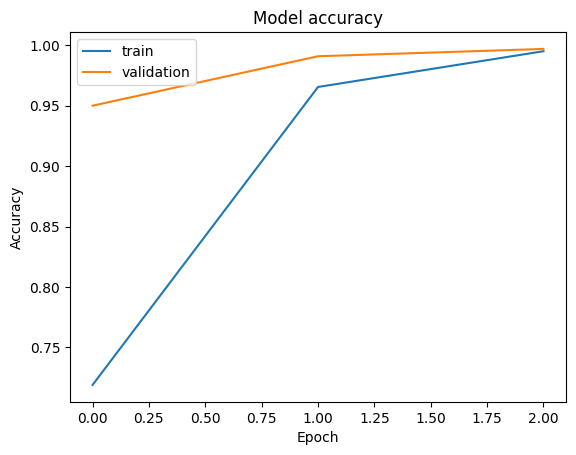

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step
              precision    recall  f1-score   support

           0       0.48      0.49      0.49       322
           1       0.51      0.51      0.51       338

    accuracy                           0.50       660
   macro avg       0.50      0.50      0.50       660
weighted avg       0.50      0.50      0.50       660

True labels: [0 1 0 0 0 0 1 0 0 0]
Predictions: [0 0 0 0 0 1 0 1 0 0]
Shape of true_labels: (660,)
Shape of predictions: (660,)


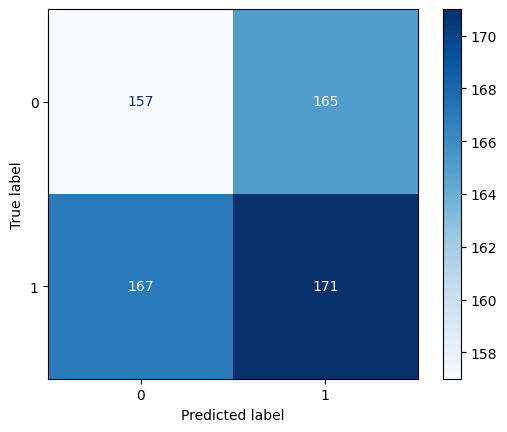

In [23]:
# DIstorsion3

model=create_model()
distorsion3_dir = os.path.join(train_base_dir, 'distorsion3')
process_model(model,distorsion3_dir)




# Flou Mouvement

In [ ]:
# Mvt1

model=create_model()
mvt1_dir = os.path.join(train_base_dir, 'mvt1')
process_model(model,mvt1_dir)



Distribution des labels dans le jeu d'entraînement: [1289 1406]
Distribution des labels dans le jeu de validation: [322 352]
Epoch 1/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 158s 4s/step - accuracy: 0.6067 - loss: 2.7310 - val_accuracy: 0.9139 - val_loss: 0.2704
Epoch 2/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 156s 4s/step - accuracy: 0.9421 - loss: 0.1787 - val_accuracy: 0.9896 - val_loss: 0.0421
Epoch 3/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 156s 4s/step - accuracy: 0.9845 - loss: 0.0441 - val_accuracy: 0.9941 - val_loss: 0.0257
Epoch 4/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 156s 4s/step - accuracy: 0.9951 - loss: 0.0186 - val_accuracy: 0.9985 - val_loss: 0.0110
Epoch 5/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 155s 4s/step - accuracy: 0.9999 - loss: 0.0036 - val_accuracy: 0.9985 - val_loss: 0.0102


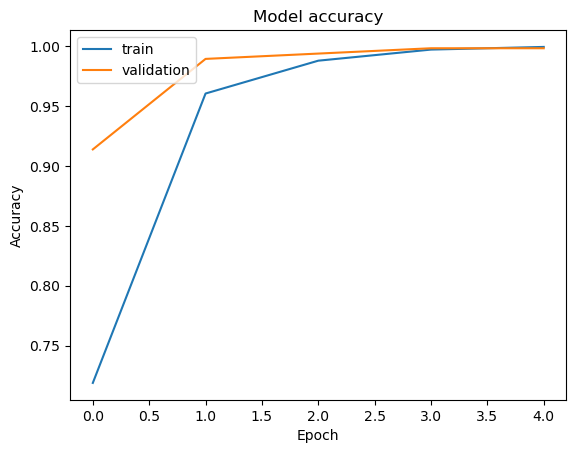

11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 931ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       322
           1       1.00      1.00      1.00       352

    accuracy                           1.00       674
   macro avg       1.00      1.00      1.00       674
weighted avg       1.00      1.00      1.00       674

True labels: [0 1 1 0 0 1 0 1 1 1]
Predictions: [0 1 1 0 0 1 0 1 1 1]
Shape of true_labels: (674,)
Shape of predictions: (674,)


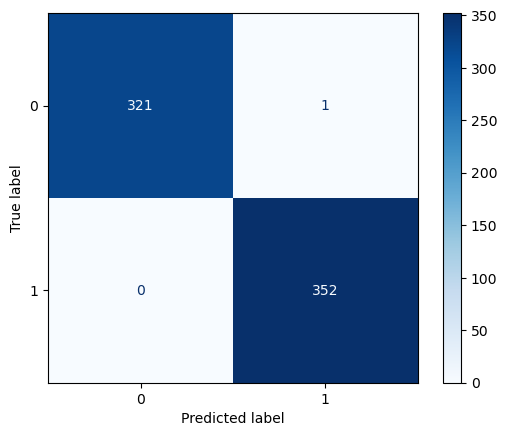

In [9]:
# Mvt2

model=create_model()
mvt2_dir = os.path.join(train_base_dir, 'mvt2')
process_model(model,mvt2_dir)


In [ ]:
# Mvt3

model=create_model()
mvt3_dir = os.path.join(train_base_dir, 'mvt3')
process_model(model,mvt3_dir)



# Flou gaussien

In [ ]:
# Gauss1

model=create_model()
gauss1_dir = os.path.join(train_base_dir, 'gauss1')
process_model(model,gauss1_dir)



In [ ]:
# Gauss2

model=create_model()
gauss2_dir = os.path.join(train_base_dir, 'gauss2')
process_model(model,gauss2_dir)


Distribution des labels dans le jeu d'entraînement: [1289 1342]
Distribution des labels dans le jeu de validation: [322 336]
Epoch 1/5


2024-11-13 10:03:48.526458: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


42/42 ━━━━━━━━━━━━━━━━━━━━ 158s 4s/step - accuracy: 0.5377 - loss: 2.1812 - val_accuracy: 0.9711 - val_loss: 0.3333
Epoch 2/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 157s 4s/step - accuracy: 0.9475 - loss: 0.2306 - val_accuracy: 0.9909 - val_loss: 0.0476
Epoch 3/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 157s 4s/step - accuracy: 0.9757 - loss: 0.0687 - val_accuracy: 0.9939 - val_loss: 0.0215
Epoch 4/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 173s 4s/step - accuracy: 0.9941 - loss: 0.0276 - val_accuracy: 0.9909 - val_loss: 0.0330
Epoch 5/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 172s 4s/step - accuracy: 0.9970 - loss: 0.0141 - val_accuracy: 0.9863 - val_loss: 0.0446


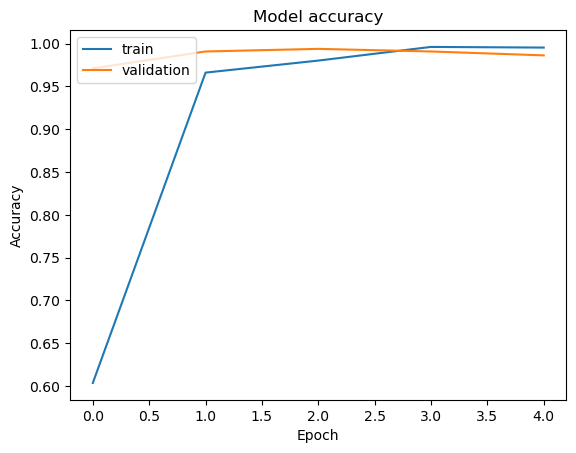

11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 954ms/step
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       322
           1       1.00      0.97      0.99       336

    accuracy                           0.99       658
   macro avg       0.99      0.99      0.99       658
weighted avg       0.99      0.99      0.99       658

True labels: [1 1 1 0 0 1 1 1 0 0]
Predictions: [1 1 1 0 0 1 1 1 0 0]
Shape of true_labels: (658,)
Shape of predictions: (658,)


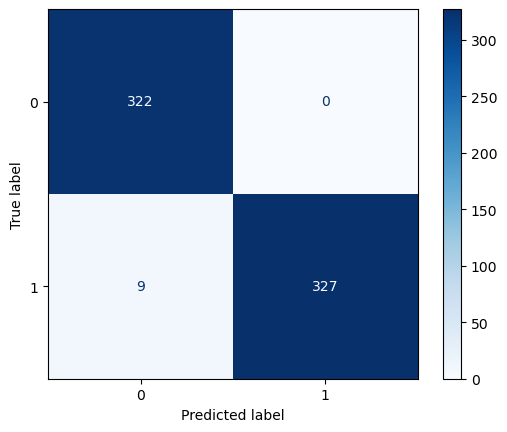

In [8]:
# Gauss3

model=create_model()
gauss3_dir = os.path.join(train_base_dir, 'gauss3')
process_model(model,gauss3_dir)


# Pixelisation

In [ ]:
# Pixel1

model=create_model()
pixel1_dir = os.path.join(train_base_dir, 'pixel1')
process_model(model,pixel1_dir)


In [ ]:
# Pixel2

model=create_model()
pixel2_dir = os.path.join(train_base_dir, 'pixel1')
process_model(model,pixel2_dir)

Distribution des labels dans le jeu d'entraînement: [1288 1217]
Distribution des labels dans le jeu de validation: [323 304]
Epoch 1/5


2024-11-13 08:31:05.983857: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


40/40 ━━━━━━━━━━━━━━━━━━━━ 157s 4s/step - accuracy: 0.6195 - loss: 1.2969 - val_accuracy: 0.8501 - val_loss: 0.2997
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 147s 4s/step - accuracy: 0.8433 - loss: 0.2825 - val_accuracy: 0.7959 - val_loss: 0.3277
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.9184 - loss: 0.1959 - val_accuracy: 0.9219 - val_loss: 0.1781
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step - accuracy: 0.9688 - loss: 0.0826 - val_accuracy: 0.8852 - val_loss: 0.2142
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 147s 4s/step - accuracy: 0.9864 - loss: 0.0562 - val_accuracy: 0.9426 - val_loss: 0.1472


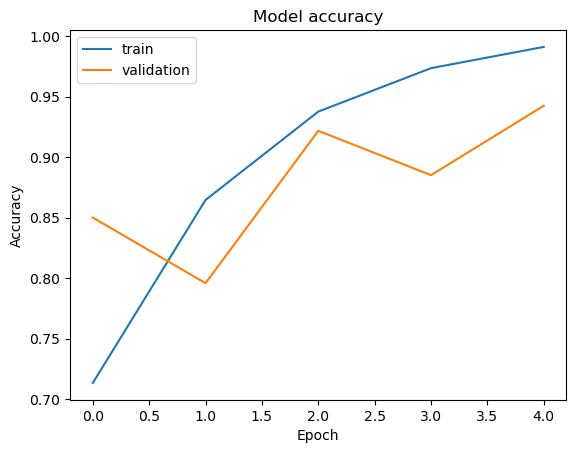

10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 960ms/step
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       323
           1       0.98      0.90      0.94       304

    accuracy                           0.94       627
   macro avg       0.95      0.94      0.94       627
weighted avg       0.94      0.94      0.94       627

True labels: [1 0 0 1 1 0 1 1 0 0]
Predictions: [1 0 0 1 1 0 1 0 0 0]
Shape of true_labels: (627,)
Shape of predictions: (627,)


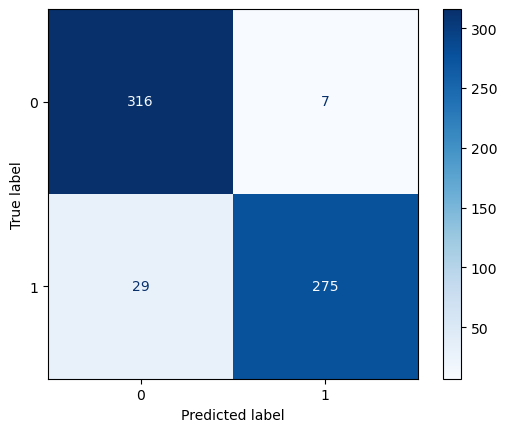

In [11]:
# Pixel3

model=create_model()
pixel3_dir = os.path.join(train_base_dir, 'pixel3')
process_model(model,pixel3_dir)